## Some imports

In [ ]:
# Install all solvers
# !pip install "qpsolvers[open_source_solvers]"

In [ ]:
import numpy as np
import sympy as sp
import time
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qpsolvers import solve_qp

In [74]:
gaps = []

## frank-wolfe algorithm

In [75]:
def f(Q, q, x):
    return (1/2 * x.T @ Q @ x + q.T @ x)[0][0]

def frank_wolfe(Q, q, x0, partitions, max_iter=100, eps=1e-6, interactive=False, verbose=False, step_size='hyperbolic'):
    x = x0
    for k in range(max_iter):
        # Compute the gradient
        grad = Q @ x + q

        s = np.zeros_like(q) # direction vector
        for part in partitions:
            if len(part) == 0:
                continue

            min_index = part[np.argmin(grad[part])]
            s[min_index] = 1
            

        # Compute the step size
        if step_size == 'hyperbolic':
            alpha = 2 / (k + 2)
        elif step_size == 'exact':
            alpha = - ((np.dot(q.T, (s - x)) + np.dot((s - x).T, Q @ x)) / np.dot((s - x).T, (Q @ (s - x))))[0][0] 
            if alpha > 1:
                alpha = 1  
   
        # Update the solution
        x_new = (1 - alpha) * x + alpha * s
        
        # Compute Frank–Wolfe gap
        gap = np.dot(grad.T, (x - s))[0][0]
        gaps.append(gap)
        if gap <= eps:
            print(f"Stopping criterion reached (gap ≤ {eps}).")
            break
        
        if verbose:
            print(f"Iteration {k}:")
            # print(f"x = \n{x}")
            # print(f"s = \n{s}")
            print(f"diff = \n{x_new - x}")
            # print(f"s_index = {np.where(s == 1)[0]}")
            # print(f"f(x) = \n{f(Q, q, x)}")
            # print(f"gradient_norm = {np.linalg.norm(grad)}\n")
            print(f"alpha = {alpha}")
            print(f"gap = {gap}\n")
        
        x = x_new
       

        if interactive:
            input("Press Enter to continue...")
    
    return x

## generate Q matrix

In [76]:
# Generate a random square matrix
n = 200  # Size of the matrix
matrix = np.random.rand(n, n)
# matrix = matrix * np.random.randint(1, 10)

Q = (matrix.T @ matrix + 4*np.eye(n) ).astype(np.float64)  # Ensure positive definiteness
q = np.random.rand(n, 1).astype(np.float64)

eigenvalues = np.linalg.eigvals(Q)
eigenvalues = sorted(eigenvalues, reverse=True)

sp.init_printing(use_latex=True)
# dispQ = sp.Matrix(Q)
# dispq = sp.Matrix(q)
# dispeig = sp.Matrix(eigenvalues)
# print("Q:")
# display(dispQ)
# print()
# print("q:")
# display(dispq)
# print()
# print("Eigenvalues of Q:")
# display(dispeig)

In [77]:
# print("Q:")
# display(dispQ)
# print()
# print("q:")
# display(dispq)
# print()
# print("Eigenvalues of Q:")
# display(dispeig)

In [78]:
# import plotly.graph_objects as go

# # Define the grid for plotting
# x_vals = np.linspace(0, 1, 100)
# y_vals = np.linspace(0, 1, 100)
# X, Y = np.meshgrid(x_vals, y_vals)

# # Compute Z values for the function f
# Z = np.zeros_like(X)
# for i in range(X.shape[0]):
#     for j in range(X.shape[1]):
#         x_vec = np.array([[X[i, j]], [Y[i, j]]])
#         Z[i, j] = f(Q, q, x_vec)

# # Create the 3D surface plot
# fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])

# # Add labels and title
# fig.update_layout(
#     title="3D Plot of the Function f",
#     scene=dict(
#         xaxis_title="x1",
#         yaxis_title="x2",
#         zaxis_title="f(x)"
#     )
# )

# # Display the interactive plot
# fig.show()


## Generate constraints

In [79]:
# n_partitions = np.random.randint(1, n//2)
n_partitions = n // 4
partitions = [[] for i in range(n_partitions)]
index = np.random.permutation(n)
for i in range(2*n_partitions):
    partitions[i % n_partitions].append(index[i])

# distribute the other elements randomly
for i in range(2*n_partitions, n):
    partitions[np.random.randint(0, n_partitions)].append(index[i])

print(f"Partitions amount: {n_partitions}")
for i in range(n_partitions):
    print(partitions[i])

Partitions amount: 50
[np.int64(30), np.int64(96), np.int64(81)]
[np.int64(93), np.int64(55), np.int64(95)]
[np.int64(3), np.int64(89), np.int64(101), np.int64(175)]
[np.int64(137), np.int64(187), np.int64(197), np.int64(130)]
[np.int64(112), np.int64(68)]
[np.int64(33), np.int64(158), np.int64(16), np.int64(179)]
[np.int64(71), np.int64(135), np.int64(186), np.int64(162), np.int64(146)]
[np.int64(189), np.int64(73), np.int64(194)]
[np.int64(156), np.int64(26), np.int64(125), np.int64(176), np.int64(80), np.int64(173), np.int64(193)]
[np.int64(144), np.int64(183), np.int64(152)]
[np.int64(160), np.int64(163)]
[np.int64(138), np.int64(74), np.int64(59), np.int64(191), np.int64(99), np.int64(185)]
[np.int64(9), np.int64(198), np.int64(143), np.int64(199), np.int64(117), np.int64(64)]
[np.int64(129), np.int64(105), np.int64(172), np.int64(32), np.int64(132)]
[np.int64(19), np.int64(57)]
[np.int64(111), np.int64(51), np.int64(141), np.int64(82)]
[np.int64(128), np.int64(28), np.int64(20), 

## Starting point

In [80]:
x0 = np.zeros((n, 1), dtype=np.float64)
for part in partitions:
    if len(part) == 0:
        continue
    x0[np.random.choice(part)] = 1
print("x0:")
dispx0 = sp.Matrix(x0)
# display(dispx0)

x0:


## Optimization

Step type: hyperbolic
Elapsed time: 25.48 seconds
ratio =  1.0789400113796623
Step type: exact
Elapsed time: 27.60 seconds
ratio =  1.0399144957250577


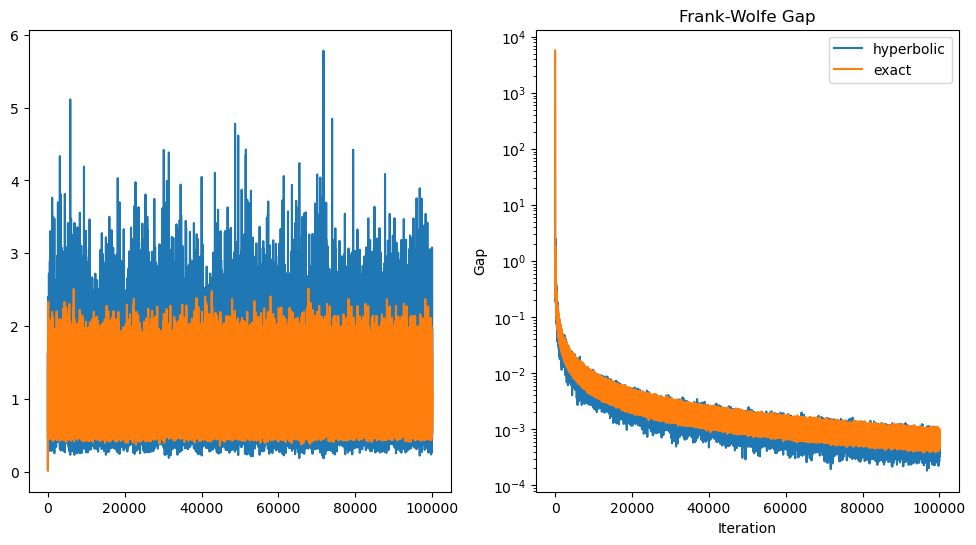

In [81]:
gaps = []

plt.figure(figsize=(12, 6))
for step_type in ("hyperbolic", "exact"):
    gaps = []
    print(f"Step type: {step_type}")
    t0 = time.time()
    x_star = frank_wolfe(Q, q, x0, partitions, max_iter=100000, eps=1e-8, interactive=False, verbose=False, step_size=step_type)
    t1 = time.time()
    print(f"Elapsed time: {t1 - t0:.2f} seconds")

    # print("x_star:")
    # dispx_star = sp.Matrix(x_star)
    # display(dispx_star)

    steps = 2
    # steps = 300
    ratios = [gaps[i+steps] / gaps[i] for i in range(len(gaps)-steps)]

    print(f"ratio = ", np.mean(ratios))

    # plot
    plt.subplot(1, 2, 1)
    plt.plot(ratios, label=step_type)
    plt.subplot(1, 2, 2)
    plt.plot(gaps, label=step_type)

    plt.xlabel("Iteration")
    plt.ylabel("Gap")
    plt.title("Frank-Wolfe Gap")
    plt.yscale("log")
    plt.legend()
    plt.grid()

plt.show()

In [82]:
# x_star = frank_wolfe(Q, q, x0, partitions, max_iter=200, eps=1e-8, interactive=False, verbose=True, step_size=step_type)

In [83]:
# for part in partitions:
#     print(sum(x_star[part]))

In [84]:
precision = 50  # Change this value to adjust precision
np.set_printoptions(precision=precision, suppress=True)

for part in partitions:
    print(x_star[part])

[[0.                    ]
 [0.00001663435216210385]
 [0.99998336564784      ]]
[[0.3241034144539156]
 [0.                ]
 [0.6758965855460819]]
[[1.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [1.]
 [0.]
 [0.]]
[[1.]
 [0.]]
[[0.]
 [1.]
 [0.]
 [0.]]
[[0.                     ]
 [0.                     ]
 [0.                     ]
 [0.000012260202186116297]
 [0.999987739797813      ]]
[[0.]
 [0.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]
[[0.]
 [1.]
 [0.]]
[[0.7933165906053866 ]
 [0.20668340939462296]]
[[0.                 ]
 [0.8313804257727905 ]
 [0.                 ]
 [0.                 ]
 [0.                 ]
 [0.16861957422720836]]
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]
[[0.                     ]
 [0.999987739797813      ]
 [0.                     ]
 [0.                     ]
 [0.000012260202186116297]]
[[1.]
 [0.]]
[[0.08924638460179779]
 [0.                 ]
 [0.                 ]
 [0.9107536153982179 ]]
[[0.4179505359019206 ]
 [0.                 ]
 [0.5183976113479666 ]
 [0.           

## SLSQP

Elapsed time: 2.97 seconds

Plotting convergence history...


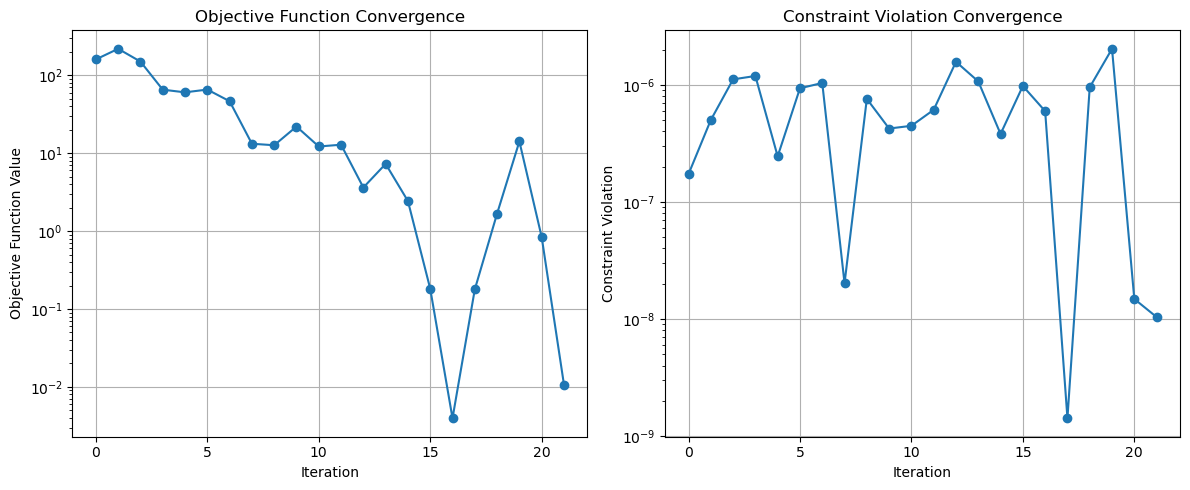

In [85]:

# objective function f(x) = 1/2 x^T Q x + q^T x
def objective(x):
    return 0.5 * x @ (Q @ x) + q.flatten() @ x

# bounds 0 ≤ x_i ≤ 1
bounds = [(0, 1)] * n

# for each partition, the sum of the x's in that block must be 1
constraints = [
    {'type': 'eq', 'fun': lambda x, part=part: x[part].sum() - 1}
    for part in partitions
]

x0_flat = x0.flatten()

# Lists to store convergence data
iteration_history = []
objective_history = []
violation_history = []
gap_history = []
call_count = 0 # To track the iteration number

def my_callback(xk):
    """Callback function called after each iteration."""
    global call_count # Need global to modify the counter
    global iteration_history, objective_history, constraint_violation_history
    # Ensure objective and partitions are accessible from here (they should be if defined globally or in the same scope)

    # Record iteration number
    iteration_history.append(call_count)
    call_count += 1 # Increment for the next call

    # Compute the gradient
    xk = xk.reshape(-1, 1)  # Reshape xk to be a column vector
    grad = Q @ xk + q
    s = np.zeros_like(q)
    for part in partitions:
        min_index = part[np.argmin(grad[part])]
        s[min_index] = 1

    # Compute Frank–Wolfe gap
    gap = np.dot(grad.T, (xk - s))[0][0]
    gap_history.append(gap)

    # check feasibility violation
    sum_violations = 0
    for part in partitions:
        sum_violations += abs(xk[part].sum() - 1)
    violation_history.append(sum_violations)
t0 = time.time()

res = minimize(objective,
                x0_flat,
                method='SLSQP',
                bounds=bounds,
                constraints=constraints,
                callback=my_callback,
                tol=1e-20,
)

t1 = time.time()
print(f"Elapsed time: {t1 - t0:.2f} seconds")

print("\nPlotting convergence history...")

if iteration_history: # Only plot if callback was called at least once
    plt.figure(figsize=(12, 5))

    # Plot Objective Function Value
    plt.subplot(1, 2, 1)
    plt.plot(iteration_history, gap_history, marker='o', linestyle='-')
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.title("Objective Function Convergence")
    plt.grid(True)
    plt.yscale('log')

    # Plot Constraint Violation
    plt.subplot(1, 2, 2)
    plt.plot(iteration_history, violation_history, marker='o', linestyle='-')
    plt.xlabel("Iteration")
    plt.ylabel("Constraint Violation")
    plt.title("Constraint Violation Convergence")
    plt.grid(True)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
else:
    print("No convergence history recorded (callback might not have been triggered).")


In [86]:
### using a QP solver
## write the equality constraints in the form Ax = b
A = np.zeros((n_partitions, n))
b = np.zeros((n_partitions, 1))
for i in range(n_partitions):
    A[i, partitions[i]] = 1
    b[i] = 1

lb = np.zeros((n, 1))
ub = np.ones((n, 1))

# qpsolvers.available_solvers = ['clarabel', 'cvxopt', 'daqp', 'ecos', 
# 'gurobi', 'highs', 'hpipm', 'jaxopt_osqp', 'kvxopt', 'mosek', 'osqp', 
# 'piqp', 'proxqp', 'qpalm', 'qpax', 'qpoases', 'qpswift', 'quadprog', '
# scs', 'sip', 'nppro']

x_qp = solve_qp(Q, q.flatten(), A=A, b=b.flatten(), solver="daqp", lb=lb.flatten(), ub=ub.flatten())
x_qp = x_qp.reshape(-1, 1)
f(Q, q, x_qp)

SLSQP status: Positive directional derivative for linesearch
SLSQP Objective value: 58118.78893232309
QP solver objective:  58118.788906367285
Our value: 58118.78919001832
x (SLSQP):


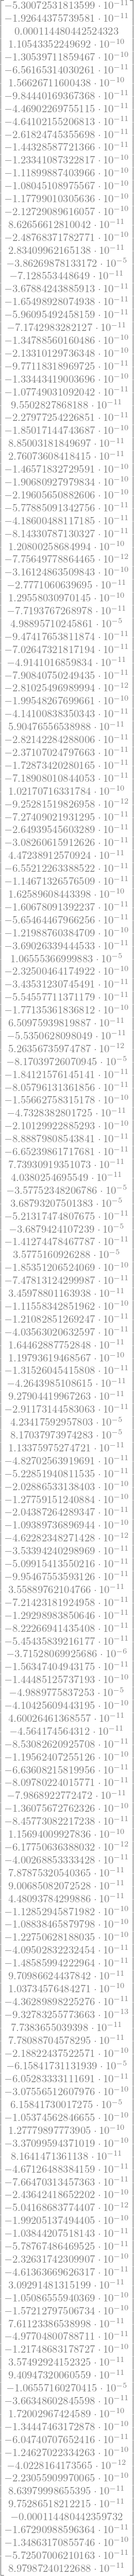

In [ ]:
# reshape solution
x_SLSQP = res.x.reshape(-1, 1)

# Set precision for displaying results
precision = 10  # Change this value to adjust precision
np.set_printoptions(precision=precision, suppress=True)

print("SLSQP status:", res.message)
print("SLSQP Objective value:", res.fun)
print("QP solver Objective Value: ", f(Q, q, x_qp))
print(f"Our value: {f(Q, q, x_star)}")
print("x (SLSQP):")
diff = x_qp - x_SLSQP
display(sp.Matrix(diff))